### IT Security and Privacy
### HU WS 2019/2020
# Extremism Detection: BERT Model


*Amanda Maiwald, 599665, maiwald@posteo.de* \\
*Lukas Baumann, 597742, lukasb94@gmx.de* \\
Simon Rähles, 600785, s.raehles@me.com \\

---

# Setup

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
import random

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing import text, sequence
from keras.layers import Embedding, SpatialDropout1D
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.optimizers import RMSprop
import keras.backend as K
from keras.layers import Dense, Input, GRU, LSTM, Bidirectional, Dropout, CuDNNLSTM, CuDNNGRU
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Amanda's directory structure
input_dir_am = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Input/"
output_dir_am = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Output/"

In [0]:
# Amanda directory structure
base_dir = '/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/'
data_dir = base_dir + 'Input/'
model_dir = base_dir + 'Model_Output_BERT'
output_dir = output_dir_am

In [0]:
df = pd.read_csv(data_dir + 'df_downsampled.csv') 
afd = pd.read_csv(data_dir + 'df_afd.csv') 

In [0]:
df.head(1)

,Unnamed: 0,Unnamed: 0.1,user,id,permalink,to,text,date,retweets,favorites,mentions,hashtags,geo,name,party,position,since,label
0,277085,100921,katjadoerner,129128258263449601,https://twitter.com/katjadoerner/status/129128...,NaN,"Wer Rettungsschirm gesagt hat, muss Hebel sage...",2011-10-26 09:32:30+00:00,3.0,0.0,NaN,NaN,NaN,Katja Dörner,Gruene,MdB,2009-01-01,non_extremist


# Data Preprocessing

In [0]:
# fill in case text is empty
df.text.fillna("empty", inplace=True)
afd.text.fillna("empty", inplace=True)

# drop unnecessary columns
df.drop(df.columns[[0, 1]], axis = 1, inplace = True) 
afd.drop(afd.columns[[0, 1]], axis = 1, inplace = True) 

In [0]:
# "CDU " to "CDU"
df['party'] = df['party'].replace('CDU ', 'CDU')

In [0]:
# remove parties from the tweets
import re
parties = ['spd', 'ddw', 'afd', 'linke', 'cdu', 'npd', 'gruene', 'grüne','fdp', 'csu']
partiesRegex = re.compile("|".join(parties), re.IGNORECASE)
sent = 'This Person is a member of the SPD and spd http.fe'
partiesRegex.sub("", sent)

'This Person is a member of the  and  http.fe'

In [0]:
# remove party names from text
df['text'] =  df['text'].apply(lambda x: partiesRegex.sub("", str(x)))
afd['text'] =  afd['text'].apply(lambda x: partiesRegex.sub("", str(x)))

In [0]:
# remove links and non alphabetic letters
df['text'] =  df['text'].apply(lambda x: re.sub(r'http\S+'," ", str(x), flags=re.MULTILINE))
df['text'] =  df['text'].apply(lambda x: re.sub("[^a-zöüäA-ZÜÖÄ]"," ", str(x)))

afd['text'] =  afd['text'].apply(lambda x: re.sub(r'http\S+'," ", str(x), flags=re.MULTILINE))
afd['text'] =  afd['text'].apply(lambda x: re.sub("[^a-zöüäA-ZÜÖÄ]"," ", str(x)))

In [0]:
# split into stratified train, validation and test set
from sklearn.model_selection import train_test_split
RS = 42
X_train, X_test, y_train, y_test  = train_test_split(df, df.label, stratify=df.label, test_size=0.10, random_state=RS)
X_train, X_val, y_train, y_val  = train_test_split(X_train, X_train.label, stratify=X_train.label, test_size=0.25, random_state=RS)

In [0]:
# create test data set WITH afd tweets
afd_sample = afd.sample(1000, random_state = RS)
afd_sample["label"] = "extremist"
X_afd = afd_sample.append(X_test)
y_afd = afd_sample.label
y_afd = y_afd.append(y_test)

In [0]:
y_afd.describe() # test has 3428 extremist tweets

count          5855
unique            2
top       extremist
freq           3428
Name: label, dtype: object

In [0]:
print("df shape: ", df.shape)
print("Shape of X")
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_afd shape: ", X_afd.shape)
print("Shape of y")
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_afd shape: ", y_afd.shape)

df shape:  (48544, 16)
Shape of X
X_train shape:  (32766, 16)
X_val shape:  (10923, 16)
X_afd shape:  (5855, 16)
Shape of y
y_train shape:  (32766,)
y_val shape:  (10923,)
y_afd shape:  (5855,)


# Model


In [0]:
# Parameters
MAXLEN = 41 # was 256
DROPOUT = 0
RS = 42
EPOCHS = 4
BATCHSIZE = 64 # was 32
MAX_LR=3e-5

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
#BERT = "bert-base-uncased"
BERT = "bert-base-multilingual-cased"

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name=BERT,
    max_lr=MAX_LR,
    epochs=EPOCHS,
    use_fp16=True,
    bs=BATCHSIZE,
    discriminative=False,
    max_seq_len=MAXLEN,
)

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [0]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
train = X_train.copy()
val = X_val.copy()
test = X_afd.copy()

In [0]:
# better format for following functions
#train = pd.DataFrame(np.stack((X_train, pd.DataFrame(y_train)), axis = 1)).rename(columns={0: "text", 1: "extremist"})
#val = pd.DataFrame(np.stack((X_val, y_val), axis = 1)).rename(columns={0: "text", 1: "extremist"})
#test = pd.DataFrame(np.stack((X_afd, y_afd), axis = 1)).rename(columns={0: "text", 1: "extremist"})

In [0]:
train.label = train.label == "extremist" # 1 = extremist, 0 = non_extremist
train.label = train.label.astype(int)
val.label = val.label == "extremist"
val.label = val.label.astype(int)
test.label = test.label == "extremist"
test.label = test.label.astype(int)

In [0]:
test.tail()

,user,id,permalink,to,text,date,retweets,favorites,mentions,hashtags,geo,name,party,position,since,label
29707,FrankFranz,387642073265889280,https://twitter.com/FrankFranz/status/38764207...,NaN,Sieht relativ eindeutig aus,2013-10-08 18:14:07+00:00,1.0,1.0,NaN,NaN,NaN,Frank Franz,NPD,Parteivorsitzender,2009-03-01,1
36046,RicardaRiefling,376244271969755136,https://twitter.com/RicardaRiefling/status/376...,NaN,Es spricht Markus Walter,2013-09-07 07:23:19+00:00,0.0,2.0,NaN,NaN,NaN,Ricarda Riefling,NPD,Familienpolitik,2009-07-01,1
18893,ArminLaschet,1061604183353319424,https://twitter.com/ArminLaschet/status/106160...,Barbara_Schnell,Bevor sich alle weiter in Spekulationen ergehe...,2018-11-11 12:58:55+00:00,1.0,2.0,NaN,NaN,NaN,Armin Laschet,CDU,Ministerpräsident NRW,2012-09-01,0
41547,claus_cremer,39729032237027328,https://twitter.com/claus_cremer/status/397290...,NaN,Guttenberg hat bei Professor aus NRW abgeschri...,2011-02-21 16:51:54+00:00,0.0,0.0,NaN,NaN,NaN,Claus Cremer,NPD,Landesvorsitzender Nordrhein-Westphalen,2009-03-01,1
6819,MikeMohring,385436541843427328,https://twitter.com/MikeMohring/status/3854365...,NaN,Mike Mohring in den Hamburger abendblatt new...,2013-10-02 16:10:07+00:00,0.0,0.0,@abendblatt_news,#Mohring,NaN,Mike Mohring,CDU,Landesvorsitzender Thüringen,2012-12-01,0


In [0]:
config.testing = False

In [0]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
label_cols = ["label"]

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [0]:
# this will produce a virtually identical databunch to the code above
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="text",
                  label_cols="label",
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
databunch.show_batch()

text,target
[CLS] End ##lich eine P ##fe ##ifen ##rau ##cher ##in des Jahres Glück ##wu ##ns ##ch an Sonja Ki ##rch ##berger zu dieser Auszeichnung die sie letzte Woche vom V ##d ##R Ra ##ucht ##aba ##k erhielt Damit er ##obe [SEP],0
[CLS] Abs ##chie ##bec ##halle ##nge Dan ##ke Rica ##rda ##R ##ief ##ling für die Nominierung Ich bene ##nne Abdul Da ##wood ##zai den M ##ör ##der von Mia aus Kan ##del Ich nomi ##nier ##e Angela vom Thing ##T [SEP],1
[CLS] Die Wort ##wahl kommt nicht von uns das ist die Wort ##wahl der die hat diesen Begriff vermutlich ganz be ##wusst so genutzt Den ##n genau das ist es was sie plant Ein At ##tent ##at auf uns ##er [SEP],0
[CLS] Wie ##der ein Beispiel für die Abs ##urd ##ität des Hart ##z IV Regime ##s Sp ##enden für ein to ##d ##kra ##nke ##s Kind im Hart ##z IV Bezug müssen viele H ##ürde ##n nehmen um zu hel [SEP],0
[CLS] Sad but true Bei Zukunft ##s ##fragen wie dem Klima ##schutz ist Ende ##G ##ela ##ende um ein Vie ##lfa ##ches vera ##nt ##wort ##ung ##s ##be ##wusst ##er als die Staat ##s und Regierung ##schef ##s im Europäischen [SEP],0


## Training

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
from fastai.callbacks import *

learner = Learner(
    databunch,
    bert_model,
    loss_func = loss_func,
    model_dir = model_dir
    )
if config.use_fp16: learner = learner.to_fp16()

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


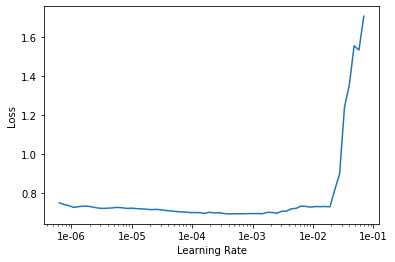

In [0]:
learner.recorder.plot()

In [0]:

learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.436606,0.383239,18:46
1,0.329723,0.311039,18:09
2,0.222657,0.323784,19:17
3,0.139443,0.376595,19:23


In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
probs = pd.DataFrame(get_preds_as_nparray(DatasetType.Test))

In [0]:
probs.head(3)

,0,1
0,0.997945,0.002055
1,0.910784,0.089216
2,0.003854,0.996146


In [0]:
#preds = pd.DataFrame(probs).idxmax(axis = 1) # col 1 is probability for extremist

In [0]:
probs["label"] = (probs.iloc[:,1]>0.5).astype(int)

In [0]:
probs.head(3)

,0,1,label
0,0.997945,0.002055,0
1,0.910784,0.089216,0
2,0.003854,0.996146,1


In [0]:
import sklearn
from sklearn import metrics

auc_pr = average_precision_score(test.label, probs.iloc[:,1])
auc_roc = roc_auc_score(test.label, probs.iloc[:,1])
f1 = sklearn.metrics.f1_score(test.label, probs["label"])

In [0]:
print("AUC PR: ", round(auc_pr,4))
print("AUC ROC: ", round(auc_roc,4))
print("F1 score: ", round(f1,4)) # threshold = 0.2

AUC PR:  0.9297
AUC ROC:  0.9024
F1 score:  0.8323


Save results in drive.

In [0]:
# create data frame with all relevant results and true labels
cols = [4,5,11,12]
bert_results = pd.DataFrame(afd.iloc[afd_sample.index,cols].append(df.iloc[X_test.index,cols]))
bert_results["true_label"] = y_afd
bert_results["true_label_binary"] = test.label
bert_results["pred_prob"] = probs.iloc[:,1].tolist()
bert_results["pred_label"] = np.where(bert_results["pred_prob"]> 0.5, 'extremist', 'non_extremist')
bert_results["pred_label_binary"] = probs["label"].tolist()
bert_results.head(10)

,text,date,name,party,true_label,true_label_binary,pred_prob,pred_label,pred_label_binary
43236,Guten Morgen was ist da los liebe Kollegen v...,2018-06-14 05:09:44+00:00,Götz Frömming,AfD,extremist,1,0.002055,non_extremist,0
42586,Warum mutma liche Linksextreme einen Physiothe...,2018-10-18 17:23:51+00:00,Götz Frömming,AfD,extremist,1,0.089216,non_extremist,0
39514,Neue Zahlen Bis über Mio Ausländer unterge...,2017-11-03 08:52:28+00:00,Malte Kaufmann,AfD,extremist,1,0.996146,extremist,1
14181,Ich glaube da ist mir ein Klarer lieber als ...,2017-08-21 18:15:22+00:00,Beatrix von Storch,AfD,extremist,1,0.448577,non_extremist,0
43669,Bürgermeister tritt bei Neuwahlen gefordert...,2018-03-30 00:00:30+00:00,Götz Frömming,AfD,extremist,1,0.732496,extremist,1
31727,Nein ehrlich Guten Morgen und willkommen in d...,2018-05-04 09:52:45+00:00,Joana Cotar,AfD,extremist,1,0.045480,non_extremist,0
21726,Parteitag der in Weinböhla Zur Eröffnung di...,2017-03-28 10:11:40+00:00,Carsten Hütter,AfD,extremist,1,0.999028,extremist,1
49839,Nimm doch ein Flugzeug,2019-11-01 16:46:56+00:00,Markus Frohnmaier,AfD,extremist,1,0.867878,extremist,1
1661,Viele Gewerke hoffen auf Rückkehr zur Meis...,2019-06-14 16:44:46+00:00,Tino Chrupalla,AfD,extremist,1,0.664540,extremist,1
39771,war live in Heidelberg Mit Dr Malte Kaufm...,2017-08-19 10:35:50+00:00,Malte Kaufmann,AfD,extremist,1,0.021677,non_extremist,0


In [0]:
# save results in drive
bert_results.to_csv(output_dir + "bert_results.csv", index=False)

In [0]:
bert_results = pd.read_csv(output_dir + 'bert_results.csv')

In [0]:
bert_results.head(3)

,text,date,name,party,true_label,true_label_binary,pred_prob,pred_label,pred_label_binary
0,Guten Morgen was ist da los liebe Kollegen v...,2018-06-14 05:09:44+00:00,Götz Frömming,AfD,extremist,1,0.002055,non_extremist,0
1,Warum mutma liche Linksextreme einen Physiothe...,2018-10-18 17:23:51+00:00,Götz Frömming,AfD,extremist,1,0.089216,non_extremist,0
2,Neue Zahlen Bis über Mio Ausländer unterge...,2017-11-03 08:52:28+00:00,Malte Kaufmann,AfD,extremist,1,0.996146,extremist,1


## Evaluation

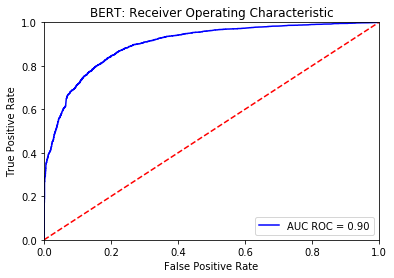

In [0]:
# plot AUC ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test.label, probs.iloc[:,1])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('BERT: Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC ROC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

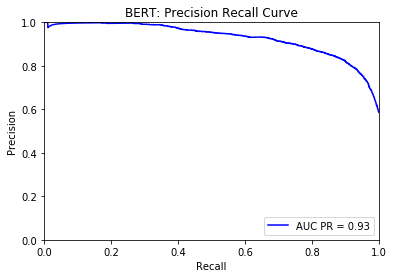

In [0]:
# plot AUC PR
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test.label, probs.iloc[:,1])
pr_auc = metrics.auc(recall, precision)

import matplotlib.pyplot as plt
plt.title('BERT: Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC PR = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [0]:
from mlxtend.evaluate import confusion_matrix
cm = confusion_matrix(y_target = bert_results.true_label_binary, 
                      y_predicted = bert_results.pred_label_binary, 
                      binary = True)
cm

array([[2071,  356],
       [ 731, 2697]])

In [0]:
tn, fp, fn, tp = confusion_matrix(y_target = bert_results.true_label_binary, 
                                  y_predicted = bert_results.pred_label_binary, 
                                  binary = True).ravel()

In [0]:
(tn, fp, fn, tp)

(2071, 356, 731, 2697)

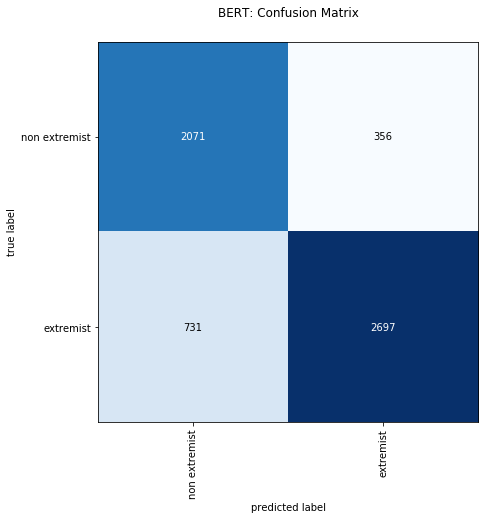

In [0]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import array

fig, ax = plot_confusion_matrix(conf_mat = cm, figsize = (7,7))
plt.title('BERT: Confusion Matrix')
plt.xticks(np.arange(2), ('non extremist', 'extremist'))
plt.xticks(rotation=90)
plt.yticks(np.arange(2), ('non extremist', 'extremist'))
plt.savefig('conf_matrix_extremist.jpg')
plt.show()

## Analysis

In [0]:
extremist_parties = pd.crosstab(bert_results.party, bert_results.pred_label)
extremist_parties["proportion"] = 100*round(extremist_parties.extremist / (extremist_parties.extremist + extremist_parties.non_extremist),4)
extremist_parties = extremist_parties.sort_values("proportion", ascending = False)

In [0]:
extremist_parties

pred_label,extremist,non_extremist,proportion
party,,,
NPD,2111,260,89.03
Die Rechte,43,14,75.44
AfD,543,457,54.30
FDP,68,359,15.93
Gruene,105,568,15.60
CDU,113,624,15.33
Die Linke,41,305,11.85
SPD,27,214,11.20


In [0]:
extremist_parties.to_csv(output_dir + "extremist_parties.csv", index=False)

In [0]:
#extremist_parties = pd.read_csv(output_dir + 'extremist_parties.csv') 

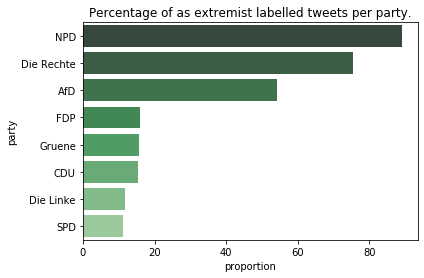

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Percentage of as extremist labelled tweets per party.") 
sns.barplot(x="proportion", y = extremist_parties.index, data=extremist_parties,
 palette="Greens_d")

In [0]:
extremist_users = pd.crosstab(bert_results.name, bert_results.pred_label)
extremist_users["proportion"] = 100*round(extremist_users.extremist / (extremist_users.extremist + extremist_users.non_extremist),4)
extremist_users = extremist_users.sort_values("proportion", ascending = False)
extremist_users = pd.merge(extremist_users, bert_results[['name', 'party']], on='name', how='left').drop_duplicates(['name'])

In [0]:
extremist_users.head(30)

,name,extremist,non_extremist,proportion,party
0,Gottfried Curio,5,0,100.00,AfD
5,Thassilo Hanutsch,3,0,100.00,NPD
8,Jean Fiedler,4,0,100.00,NPD
12,Junge Nationalisten,147,7,95.45,NPD
166,Claus Cremer,494,30,94.27,NPD
690,Jan Jaeschke,314,20,94.01,NPD
1024,Manfred Dammann,58,4,93.55,NPD
1086,Udo Voigt,77,9,89.53,NPD
1172,Frank Franz,569,85,87.00,NPD
1826,Ricarda Riefling,180,28,86.54,NPD


In [0]:
extremist_users_20 = extremist_users.loc[extremist_users['extremist'] + extremist_users['non_extremist'] > 10].head(20)

In [0]:
extremist_users_20

,name,extremist,non_extremist,proportion,party
12,Junge Nationalisten,147,7,95.45,NPD
166,Claus Cremer,494,30,94.27,NPD
690,Jan Jaeschke,314,20,94.01,NPD
1024,Manfred Dammann,58,4,93.55,NPD
1086,Udo Voigt,77,9,89.53,NPD
1172,Frank Franz,569,85,87.00,NPD
1826,Ricarda Riefling,180,28,86.54,NPD
2034,NPD Marzahn,11,2,84.62,NPD
2047,Ronny Zasowk,147,33,81.67,NPD
2227,Markus Walter,33,9,78.57,NPD


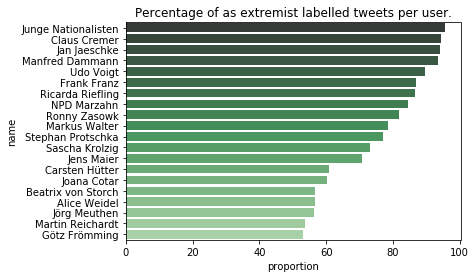

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Percentage of as extremist labelled tweets per user.") 
sns.barplot(x="proportion", y = "name", data=extremist_users_20,
 palette="Greens_d")

In [0]:
# save results in drive
#extremist_users.to_csv(output_dir + "bert_extremist_users.csv", index=False)
#extremist_users_20.to_csv(output_dir + "bert_extremist_users_20.csv", index=False)

In [0]:
#extremist_users_20 = pd.read_csv(output_dir + 'bert_extremist_users_20.csv') 

In [0]:
extremist_users_20.head(2)

,name,extremist,non_extremist,proportion,party
0,Junge Nationalisten,147,7,95.45,NPD
1,Claus Cremer,494,30,94.27,NPD


In [0]:
bert_results.loc[bert_results['name'] == "Claus Cremer"].text.tolist()

['Und wieder mehr Asylanten als erwartet   NRW wird massiv geflutet und mit den negativen Folgen wird die     ',
 'RT  NRW  Köln  Einmal mehr Asylantenkriminalität   Polizei durchsucht Übergangswohnheim   ',
 'Alles Gute und viel Erfolg im neuen Jahr   Jahreswechsel  ',
 'RT  NRW  Ostwestfälischer  Verband nun auch wieder im Netz vertreten  www  owl de',
 'Auch im Kreis  Steinfurt sind die Aktivisten weiter flei ig im Plakatiereinsatz   ',
 'Die  NRW bei Facebook und Twitter         Widerstand  Rheinland  Westfalen',
 'Zurück von einer Vortragsveranstaltung des KV Essen  wo ich gesprochen habe  Voller Saal und gute Stimmung  So lob  ich mir das ',
 'Hallo Gutmenschen  Bitte kein Gejammer  IHR habt sie mit Schildern am Bahnhof willkommen gehei en   Paris  Europa',
 'Ich habe ein neues Foto auf Facebook gepostet  ',
 'Die Polizei  München hat ein Infotelefon für die Bürger geschaltet  Telefon Nr               ',
 'Heute beim Kreiswahlausschuss in  Duisburg  wo die   als einzige rechte Kr

In [0]:
bert_results.loc[bert_results['name'] == "Claus Cremer"].pred_prob.tolist()

[0.9990490078926086,
 0.9989657402038574,
 0.2868679463863373,
 0.999206840991974,
 0.9992037415504456,
 0.9990034699440002,
 0.9991390705108644,
 0.7493624091148376,
 0.9427180886268616,
 0.7336426973342896,
 0.9992792010307312,
 0.9427180886268616,
 0.4173605740070343,
 0.9222025275230408,
 0.9973165392875672,
 0.2119872272014618,
 0.99903404712677,
 0.9990655779838562,
 0.997945249080658,
 0.9991943240165709,
 0.9992504715919496,
 0.9992129802703856,
 0.9991306662559508,
 0.9990890026092528,
 0.9222025275230408,
 0.99908185005188,
 0.9222025275230408,
 0.9991688728332521,
 0.9842759370803832,
 0.930268406867981,
 0.9988642930984496,
 0.9980657696723938,
 0.9222025275230408,
 0.9988730549812316,
 0.8715841770172119,
 0.997512936592102,
 0.9918279647827148,
 0.999243140220642,
 0.995768427848816,
 0.9991374015808104,
 0.9986302852630616,
 0.9992221593856812,
 0.9991424083709716,
 0.9991169571876526,
 0.9933330416679382,
 0.9991340041160583,
 0.9991323351860046,
 0.9984752535820008,
 0

In [0]:
bert_results.loc[bert_results['name'] == "Stephan Protschka"].text.tolist()

['Was essen Sie wenn ich fragen darf ',
 'Ich habe eine  Identität und liebe meine  Kultur und mein  Deutschland ',
 'Franz Josef  Strau  wäre heute bei uns  Das wei  die   und deswegen bekämpft sie uns vehemend  VIDEO   ',
 'Deutsches Gericht spricht Spaniern Sozialhilfe zu   JUNGE FREIHEIT  Armutseinwanderung  Europäische Union',
 'Wenn Sie diese Bilder nicht mehr sehen wollen  dann müssen Sie   wählen   EU  Urheberrecht      ',
 'Russland ist dicht  Der Rückzug aus Afghanistan jetzt ein logistischer Alptraum   russland RU  ',
 'Ich will einfach mal Danke sagen     Europawahl  Dingolfing  Landau',
 'WEN   WÄHLST   DU     via  YouTube',
 'Guten Morgen  Deutschland  Heute fehlen mir die Worte  nach dieser schrecklichen Tat in  Halle  Wünsche euch allen einen friedlichen Tag ',
 'Lasst uns dagegen Kämpfen  BITTE auch die  wähler    Freihandelsabkommen TTIP stoppen     via  YouTube',
 '   ',
 'Leichte Verletzungen zum Täter keine Antwort da er von der Polizei festgenommen wurde und eine 

In [0]:
bert_results.loc[bert_results['name'] == "Stephan Protschka"].pred_prob.tolist()

[0.7626451253890991,
 0.9990283250808716,
 0.9975513815879822,
 0.9938429594039917,
 0.3962433934211731,
 0.6038442254066467,
 0.022564494982361794,
 0.9990960359573364,
 0.9991357922554016,
 0.7381031513214111,
 0.925567090511322,
 0.994168758392334,
 0.0023459072690457106,
 0.9500414729118347,
 0.8314854502677917,
 0.9920772910118103,
 0.9971550703048706,
 0.9937222599983215,
 0.9634031057357788,
 0.9992519021034241,
 0.1149633452296257,
 0.00216576736420393,
 0.8761583566665649,
 0.9963853359222412,
 0.026556571945548058,
 0.68804931640625]